# 以LSTM演算法預測股價

## 載入相關套件 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## 判斷GPU是否存在

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 載入資料

In [3]:
df = pd.read_csv('./nlp_data/AMZN_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [4]:
df.tail()

,Date,Open,High,Low,Close,Volume,Name
3014,2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
3015,2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
3016,2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
3017,2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
3018,2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


## 繪圖

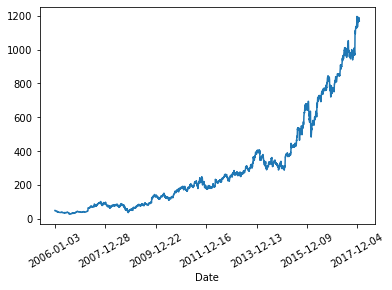

In [5]:
df2 = df.set_index('Date')
df2.Close.plot(legend=None)
plt.xticks(rotation=30);

In [6]:
len(df2)

3019

In [7]:
from sklearn.preprocessing import MinMaxScaler
look_back = 1 # 以前N期資料為 X，當期資料為 Y

# 函數：以前N期資料為 X，當前期資料為 Y
def create_dataset(data1, look_back):
    x, y = [], []
    for i in range(len(data1)-look_back-1):
        _x = data1[i:(i+look_back)]
        _y = data1[i+look_back]
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

dataset = df2[['Close']].values.astype('float32')

# X 常態化
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
dataset.shape, trainY.shape

((3019, 1), torch.Size([2020, 1]))

In [8]:
dataset[-1]

array([0.97746545], dtype=float32)

In [9]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([2020, 1, 1]),
 torch.Size([2020, 1]),
 torch.Size([995, 1, 1]),
 torch.Size([995, 1]))

In [10]:
torch.cat((trainX.reshape(trainX.shape[0], trainX.shape[1]), trainY), axis=1)

tensor([[0.0184, 0.0181],
        [0.0181, 0.0184],
        [0.0184, 0.0186],
        ...,
        [0.3205, 0.3177],
        [0.3177, 0.3120],
        [0.3120, 0.3176]])

## 建立模型

In [17]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(1, self.hidden_size, num_layers=self.num_layers
                           , batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        #print(x.shape)
        # rnn_out, h_out = self.rnn(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)        
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        #print(h_out.shape)
        
        # 取最後一層的 h，並轉成二維
#         h_out = h_out[-1].view(-1, self.hidden_size)  
#         return self.fc(h_out)
        # 取最後一個輸出，並轉成二維
        flatten_output = out[:, -1].view(-1, self.hidden_size)  
        return self.fc(flatten_output)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)

## 模型訓練

In [18]:
num_epochs = 2000
learning_rate = 0.01

def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, trainY)    
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(trainX, trainY)

torch.Size([2020, 1])
Epoch: 0, loss: 0.00651
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00001
Epoch: 1200, loss: 0.00001
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00001
Epoch: 1500, loss: 0.00001
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00003
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


## 模型評估

In [19]:
model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()
trainPredict.shape

(2020, 1)

In [20]:
trainY.shape, trainPredict.shape

(torch.Size([2020, 1]), (2020, 1))

In [21]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(2020, 1) (2020, 1)
Train RMSE: 5.90
Test RMSE:  73.33


## 繪製實際資料和預測資料的圖表

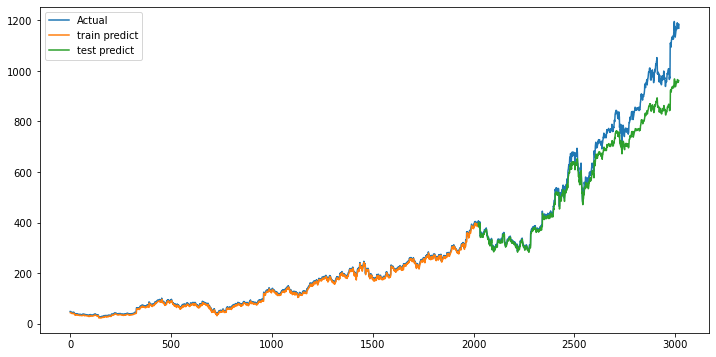

In [22]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## 改變Loopback=3：X由前1期改為前3期 

In [23]:
# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)
train(trainX, trainY)

torch.Size([2018, 1])
Epoch: 0, loss: 0.01885
Epoch: 100, loss: 0.00004
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00001
Epoch: 1200, loss: 0.00001
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00001
Epoch: 1500, loss: 0.00001
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


In [24]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(2018, 1) (2018, 1)
Train RMSE: 3.96
Test RMSE:  118.94


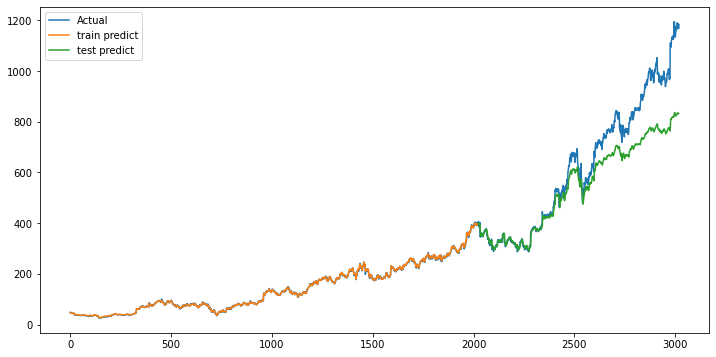

In [25]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## Stacked LSTM

In [26]:
# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=3).to(device)
train(trainX, trainY)

torch.Size([2018, 1])
Epoch: 0, loss: 0.03376
Epoch: 100, loss: 0.00369
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00004
Epoch: 900, loss: 0.00002
Epoch: 1000, loss: 0.00002
Epoch: 1100, loss: 0.00002
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


In [27]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(2018, 1) (2018, 1)
Train RMSE: 4.37
Test RMSE:  157.01


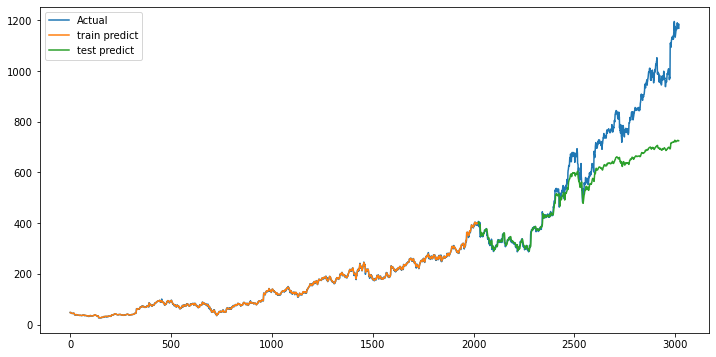

In [28]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## 預測多期

In [29]:
# 函數：以前N期資料為 X，當前期資料為 Y
def create_dataset(data1, look_back, forward_days):
    x, y = [], []
    for i in range(len(data1) - look_back - forward_days + 1):
        _x = data1[i:(i+look_back)]
        _y = data1[i+look_back:(i+look_back+forward_days)]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x), np.array(y)
    return torch.Tensor(x), torch.Tensor(y.reshape(y.shape[0], y.shape[1]))

## 建立資料集

In [30]:
look_back = 10 # 以前10期資料為 X
forward_days = 10  # 預測天數
trainX, trainY = create_dataset(train_data, look_back, forward_days)
testX, testY = create_dataset(test_data, look_back, forward_days)

In [31]:
train_data.shape, test_data.shape

((2022, 1), (997, 1))

In [32]:
trainX.shape, trainY.shape

(torch.Size([2003, 10, 1]), torch.Size([2003, 10]))

## 建立模型

In [38]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, forward_days, hidden_size=4, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(1, self.hidden_size, num_layers=self.num_layers
                           , batch_first=True)
        self.fc = nn.Linear(self.hidden_size, forward_days)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        #print(x.shape)
        # rnn_out, h_out = self.rnn(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)        
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        #print(h_out.shape)
        
        # 取最後一層的 h，並轉成二維
        # h_out = h_out[-1].view(-1, self.hidden_size)  
        # return self.fc(h_out)
        # 取最後一個輸出，並轉成二維
        flatten_output = out[:, -1].view(-1, self.hidden_size)  
        return self.fc(flatten_output)

model = TimeSeriesModel(look_back, forward_days, hidden_size=20,
                        num_layers=1).to(device)

## 模型訓練

In [39]:
def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape, trainY.shape)
        loss = criterion(outputs, trainY)    
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(trainX, trainY)

torch.Size([2003, 10]) torch.Size([2003, 10])
Epoch: 0, loss: 0.06312
Epoch: 100, loss: 0.00007
Epoch: 200, loss: 0.00005
Epoch: 300, loss: 0.00005
Epoch: 400, loss: 0.00005
Epoch: 500, loss: 0.00005
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00005
Epoch: 800, loss: 0.00005
Epoch: 900, loss: 0.00005
Epoch: 1000, loss: 0.00004
Epoch: 1100, loss: 0.00004
Epoch: 1200, loss: 0.00004
Epoch: 1300, loss: 0.00004
Epoch: 1400, loss: 0.00005
Epoch: 1500, loss: 0.00004
Epoch: 1600, loss: 0.00004
Epoch: 1700, loss: 0.00004
Epoch: 1800, loss: 0.00004
Epoch: 1900, loss: 0.00004


In [40]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(20030, 1) (2003, 10)
Train RMSE: 7.68
Test RMSE:  30.99


## 繪圖

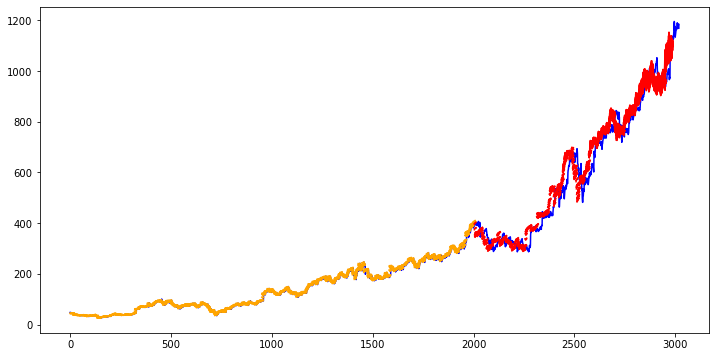

In [41]:
plt.figure(figsize=(12,6))
# 真實資料
plt.plot(range(len(dataset)), scaler.inverse_transform(dataset), 'b', label='Actual')

# 訓練資料
for i in range(trainPredict.shape[0]):
    plt.plot(range(i, i+forward_days), trainPredict[i], 'orange')

# 測試資料    
for i in range(testPredict.shape[0]):
    plt.plot(range(i+trainPredict.shape[0], i+trainPredict.shape[0]+forward_days), 
             testPredict[i], 'r')
plt.show()

## 只繪製 20 條預測值

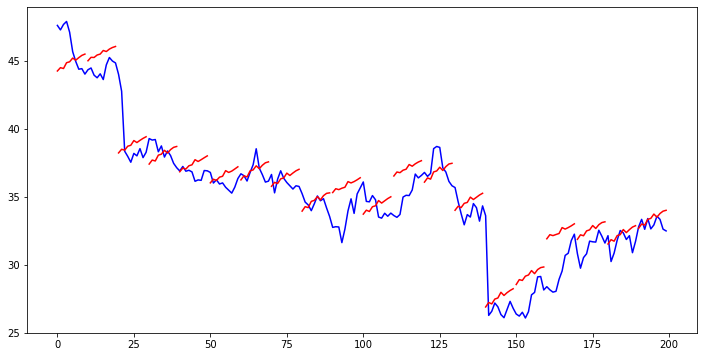

In [42]:
n = 20
plt.figure(figsize=(12,6))
# 真實資料
plt.plot(range(forward_days*n), scaler.inverse_transform(dataset[:forward_days*n]), 'b', label='Actual')

# 訓練資料
for i in range(n):
    plt.plot(range(i*forward_days, (i+1)*forward_days), trainPredict[i*forward_days], 'r')

plt.show()